In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import pandas as pd

In [4]:
from src.plotting import set_plot_style
from src.config import DATA_DIR, FIGURES_DIR
set_plot_style()

In [5]:
monthly_complete = pd.read_csv(DATA_DIR / "cleaned" / "cleaned_monthly_panel.csv", parse_dates=['Date'])

In [6]:
df = pd.read_csv(DATA_DIR / "processed" / "federal_df.csv", parse_dates=['EventDate'], low_memory=False)

In [7]:
cat_view = df.select_dtypes(include=["object", "category"])
cat_view.head()

,Employer,Address1,City,State,Primary NAICS,Final Narrative,NatureTitle,Part of Body Title,EventTitle,SourceTitle,NatureGroupLabel,BodyPartDivision
0,FCI Otisville Federal Correctional Institution,Two Mile Drive,OTISVILLE,NEW YORK,922140,Three correctional facility guards were escort...,Fractures,Lower leg(s),Injured by physical contact with person while ...,Co-worker,Unspecified traumatic injuries,Lower Extremities
1,Kalahari Manufacturing LLC,171 Progress Drive,LAKE DELTON,WISCONSIN,339999,Employee in the Machine Shop received second d...,Second degree heat (thermal) burns,"Leg(s), n.e.c.","Ignition of vapors, gases, or liquids","Welding, cutting, and blow torches",Sprains/Strains/Tears,Lower Extremities
2,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,CORAOPOLIS,PENNSYLVANIA,484121,A truck driver fell approximately 4 feet while...,"Traumatic injuries and disorders, unspecified",Nonclassifiable,Other fall to lower level less than 6 feet,"Semi, tractor-trailer, tanker truck",Other/Unclassified,Other/Unclassified
3,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,MACON,GEORGIA,424490,An employee's leg was pinned between a truck a...,"Soreness, pain, hurt-nonspecified injury","Leg(s), unspecified",Caught in or compressed by equipment or object...,Pallet jack-powered,Other traumatic injuries,Lower Extremities
4,North American Pipe Corporation,210 South Arch Street,JANESVILLE,WISCONSIN,326122,An employee working on the Line 6 Auto-Beller ...,Fractures,"Finger(s), fingernail(s), n.e.c.",Caught in running equipment or machinery durin...,"Metal, woodworking, and special material machi...",Unspecified traumatic injuries,Upper Extremities


In [8]:
num_view = df.select_dtypes(include=['int64', 'float64'])
num_view.head()

,ID,UPA,Zip,Latitude,Longitude,Hospitalized,Amputation,Nature,Part of Body,Event,Source,FederalState,Year,NatureGroup
0,2015010015,931176,10963.0,41.46,-74.53,1,0.0,111,513,1214,5721,1,2015,11
1,2015010016,930267,53940.0,43.59,-89.79,1,0.0,1522,519,317,7261,1,2015,15
2,2015010018,929823,15108.0,40.49,-80.11,1,0.0,10,9999,4331,8421,1,2015,10
3,2015010019,929711,31206.0,32.77,-83.65,1,0.0,1972,510,640,8623,1,2015,19
4,2015010020,929642,53545.0,42.67,-89.04,1,0.0,111,4429,6411,350,1,2015,11


In [9]:
unique_counts = num_view.nunique().sort_values(ascending=False)
unique_counts


UPA             96393
ID              96388
Zip             12878
Longitude        4301
Latitude         2350
Source           1425
Event             466
Nature            242
Part of Body      199
NatureGroup        29
Year               11
Hospitalized        7
Amputation          3
FederalState        1
dtype: int64

In [10]:
event_div_map = {
    "1": "Violence and other injuries by persons or animals",
    "2": "Transportation incidents",
    "3": "Fires and explosions",
    "4": "Falls, slips, trips",
    "5": "Exposure to harmful substances or environments",
    "6": "Contact with objects and equipment",
    "7": "Overexertion and bodily reaction",
    "9999": "Nonclassifiable",
}

df["EventDivision"] = (
    df["Event"].astype(str).str[:1]
)

# Map to descriptive label
df["EventDivisionLabel"] = (
    df["EventDivision"].map(event_div_map).fillna("Other/Unclassified")
)

In [11]:
df['EventDivisionLabel'].value_counts()

EventDivisionLabel
Contact with objects and equipment                   44380
Falls, slips, trips                                  29651
Transportation incidents                              8399
Exposure to harmful substances or environments        7804
Violence and other injuries by persons or animals     2142
Fires and explosions                                  1702
Overexertion and bodily reaction                      1519
Other/Unclassified                                     796
Name: count, dtype: int64

In [12]:
nature_map = {
    "11": "Unspecified traumatic injuries",
    "12": "Open wounds",
    "13": "Fractures",
    "14": "Dislocations",
    "15": "Sprains/Strains/Tears",
    "16": "Intracranial & internal injuries",
    "17": "Amputations",
    "18": "Burns/Corrosions/Scalds",
    "19": "Other traumatic injuries"
}

In [13]:
df["NatureGroup"] = (
    df["Nature"].astype(str).str[:2]
)

# Map to descriptive label
df["NatureGroupLabel"] = (
    df["NatureGroup"].map(nature_map).fillna("Other/Unclassified")
)

In [14]:
df['NatureGroupLabel'].value_counts()

NatureGroupLabel
Fractures                           30152
Unspecified traumatic injuries      28199
Other traumatic injuries            11660
Open wounds                          8339
Sprains/Strains/Tears                5375
Burns/Corrosions/Scalds              3198
Intracranial & internal injuries     3184
Other/Unclassified                   2867
Amputations                          2316
Dislocations                         1103
Name: count, dtype: int64

In [ ]:
from src.features import compute_label_mix

In [16]:
nature_mix = compute_label_mix(
    df,
    label_col="NatureGroupLabel",
    date_col="EventDate",       # <- set to your event date column name in federal_df
    state_col="State",
    freq="MS",
    top_k=10,
    out_date_col="Date",
    prefix="Nature",
    #end_date="2024-01-01"
)

event_mix = compute_label_mix(
    df,
    label_col="EventDivisionLabel",
    date_col="EventDate",
    state_col="State",
    freq="MS",
    top_k=10,
    out_date_col="Date",
    prefix="Event",
    #end_date="2024-01-01"
)

nature_mix.head()

,State,Date,share_Nature_Amputations,share_Nature_Burns/Corrosions/Scalds,share_Nature_Dislocations,share_Nature_Fractures,share_Nature_Intracranial & internal injuries,share_Nature_Open wounds,share_Nature_Other traumatic injuries,share_Nature_Other/Unclassified,share_Nature_Sprains/Strains/Tears,share_Nature_Unspecified traumatic injuries
0,ALABAMA,2015-01-01,0.000000,0.047619,0.000000,0.571429,0.000000,0.0,0.095238,0.047619,0.047619,0.190476
1,ALABAMA,2015-02-01,0.000000,0.050000,0.000000,0.450000,0.000000,0.0,0.000000,0.050000,0.100000,0.350000
2,ALABAMA,2015-03-01,0.000000,0.000000,0.040000,0.240000,0.040000,0.0,0.360000,0.080000,0.040000,0.200000
3,ALABAMA,2015-04-01,0.000000,0.000000,0.000000,0.518519,0.037037,0.0,0.111111,0.074074,0.000000,0.259259
4,ALABAMA,2015-05-01,0.032258,0.064516,0.032258,0.322581,0.064516,0.0,0.161290,0.000000,0.064516,0.258065


In [17]:
event_mix.head()

,State,Date,share_Event_Contact with objects and equipment,share_Event_Exposure to harmful substances or environments,"share_Event_Falls, slips, trips",share_Event_Fires and explosions,share_Event_Other/Unclassified,share_Event_Overexertion and bodily reaction,share_Event_Transportation incidents,share_Event_Violence and other injuries by persons or animals
0,ALABAMA,2015-01-01,0.666667,0.095238,0.095238,0.000000,0.047619,0.0,0.047619,0.047619
1,ALABAMA,2015-02-01,0.750000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000
2,ALABAMA,2015-03-01,0.400000,0.080000,0.360000,0.000000,0.000000,0.0,0.160000,0.000000
3,ALABAMA,2015-04-01,0.629630,0.037037,0.259259,0.000000,0.000000,0.0,0.074074,0.000000
4,ALABAMA,2015-05-01,0.580645,0.096774,0.193548,0.032258,0.032258,0.0,0.064516,0.000000


### Data validation

In [18]:
nature_share_cols = [c for c in nature_mix.columns if c.startswith("share_Nature_")]

nature_share_cols


['share_Nature_Amputations',
 'share_Nature_Burns/Corrosions/Scalds',
 'share_Nature_Dislocations',
 'share_Nature_Fractures',
 'share_Nature_Intracranial & internal injuries',
 'share_Nature_Open wounds',
 'share_Nature_Other traumatic injuries',
 'share_Nature_Other/Unclassified',
 'share_Nature_Sprains/Strains/Tears',
 'share_Nature_Unspecified traumatic injuries']

In [19]:
event_share_cols = [c for c in event_mix.columns if c.startswith("share_Event_")]

event_share_cols

['share_Event_Contact with objects and equipment',
 'share_Event_Exposure to harmful substances or environments',
 'share_Event_Falls, slips, trips',
 'share_Event_Fires and explosions',
 'share_Event_Other/Unclassified',
 'share_Event_Overexertion and bodily reaction',
 'share_Event_Transportation incidents',
 'share_Event_Violence and other injuries by persons or animals']

In [20]:
global_nature_mix = (
    nature_mix[nature_share_cols]
    .mean()
    .sort_values(ascending=False)
)

global_nature_mix.head(10)



share_Nature_Fractures                           0.307144
share_Nature_Unspecified traumatic injuries      0.294450
share_Nature_Other traumatic injuries            0.120430
share_Nature_Open wounds                         0.094447
share_Nature_Sprains/Strains/Tears               0.053938
share_Nature_Intracranial & internal injuries    0.035146
share_Nature_Burns/Corrosions/Scalds             0.034341
share_Nature_Other/Unclassified                  0.030249
share_Nature_Amputations                         0.018753
share_Nature_Dislocations                        0.011104
dtype: float64

In [21]:
global_event_mix = (
    event_mix[event_share_cols]
    .mean()
    .sort_values(ascending=False)
)

global_event_mix.head(10)

share_Event_Contact with objects and equipment                   0.455836
share_Event_Falls, slips, trips                                  0.318215
share_Event_Transportation incidents                             0.083122
share_Event_Exposure to harmful substances or environments       0.075402
share_Event_Violence and other injuries by persons or animals    0.022719
share_Event_Fires and explosions                                 0.019472
share_Event_Overexertion and bodily reaction                     0.016651
share_Event_Other/Unclassified                                   0.008585
dtype: float64

<Axes: >

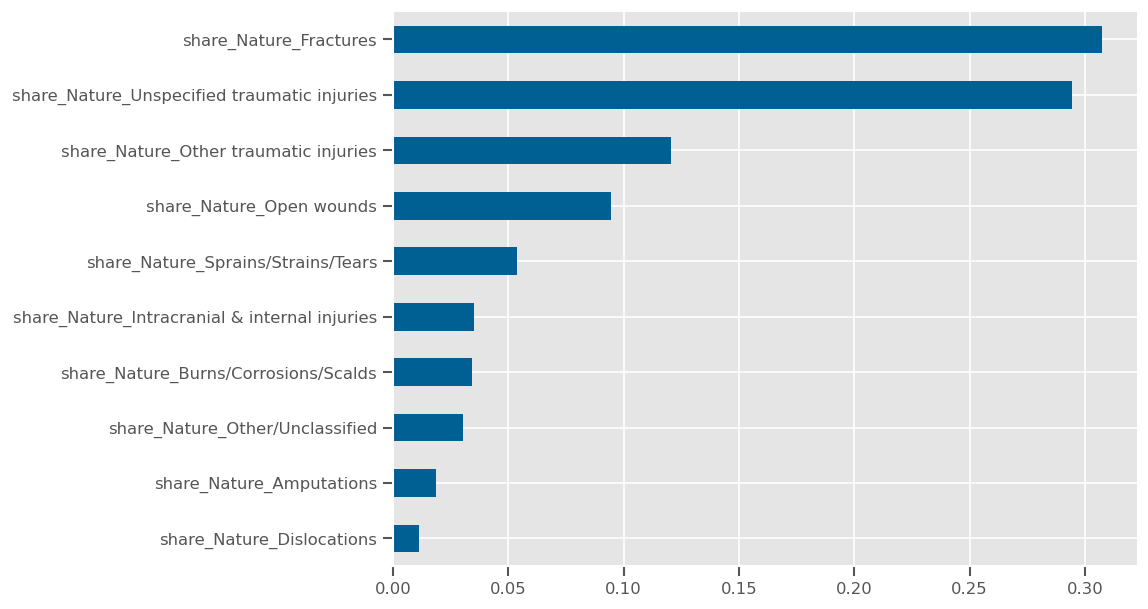

In [22]:
global_nature_mix.head(15).sort_values().plot.barh(figsize=(8, 6))


<Axes: >

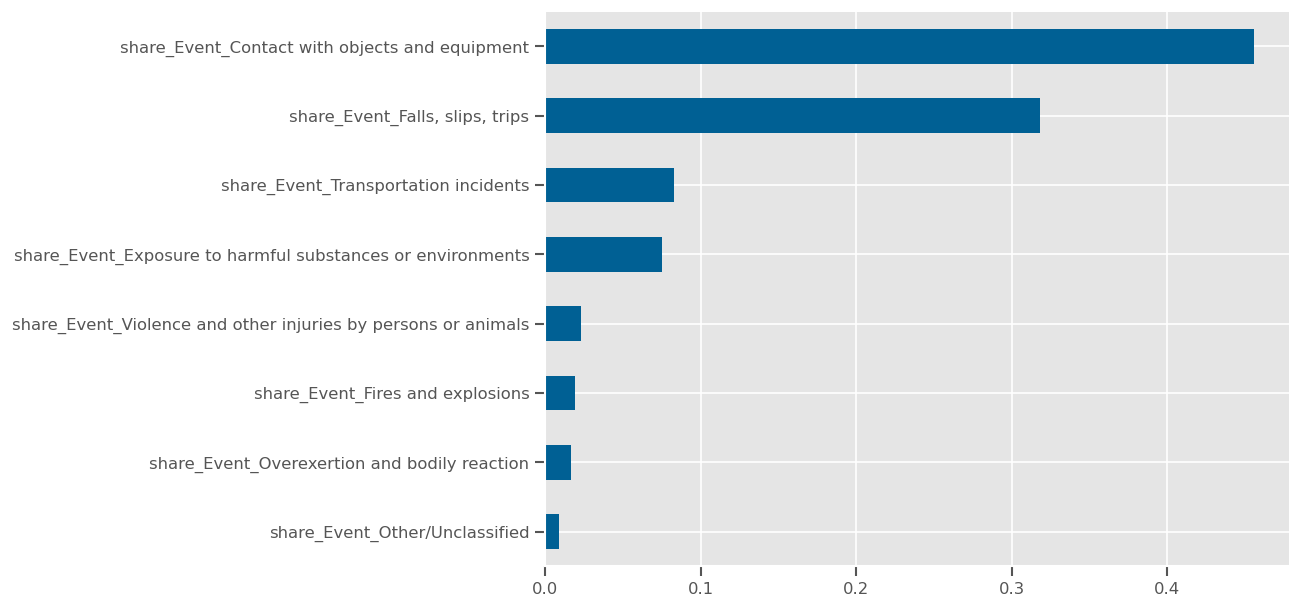

In [23]:
global_event_mix.head(15).sort_values().plot.barh(figsize=(8, 6))


In [24]:
state_nature_mix = (
    nature_mix
    .groupby("State")[nature_share_cols]
    .mean()
)


In [25]:
state_event_mix = (
    event_mix
    .groupby("State")[event_share_cols]
    .mean()
)


In [26]:
top_nature = global_nature_mix.head(5).index

state_nature_matrix = state_nature_mix[top_nature]
state_nature_matrix = state_nature_matrix.fillna(0.0)


In [27]:
top_event = global_event_mix.head(5).index

state_event_matrix = state_event_mix[top_event]
state_event_matrix = state_event_matrix.fillna(0.0)

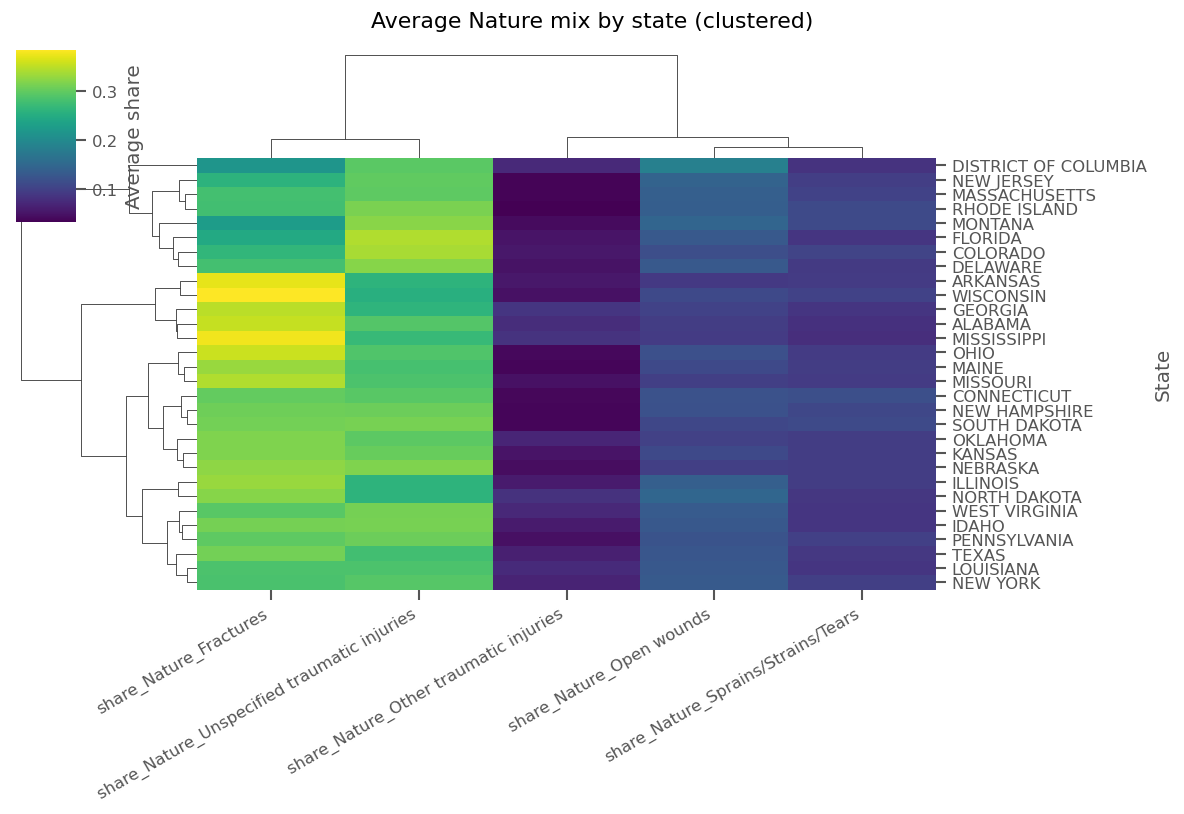

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(
    state_nature_matrix,
    cmap="viridis",
    method="ward",
    metric="euclidean",
    figsize=(10, 8),
    cbar_kws={"label": "Average share"},
)

# Fix x-axis labels
g.ax_heatmap.set_xticklabels(
    top_nature,
    rotation=30,
    ha="right"
)

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("State")
g.fig.suptitle("Average Nature mix by state (clustered)", y=1.02)

plt.show()


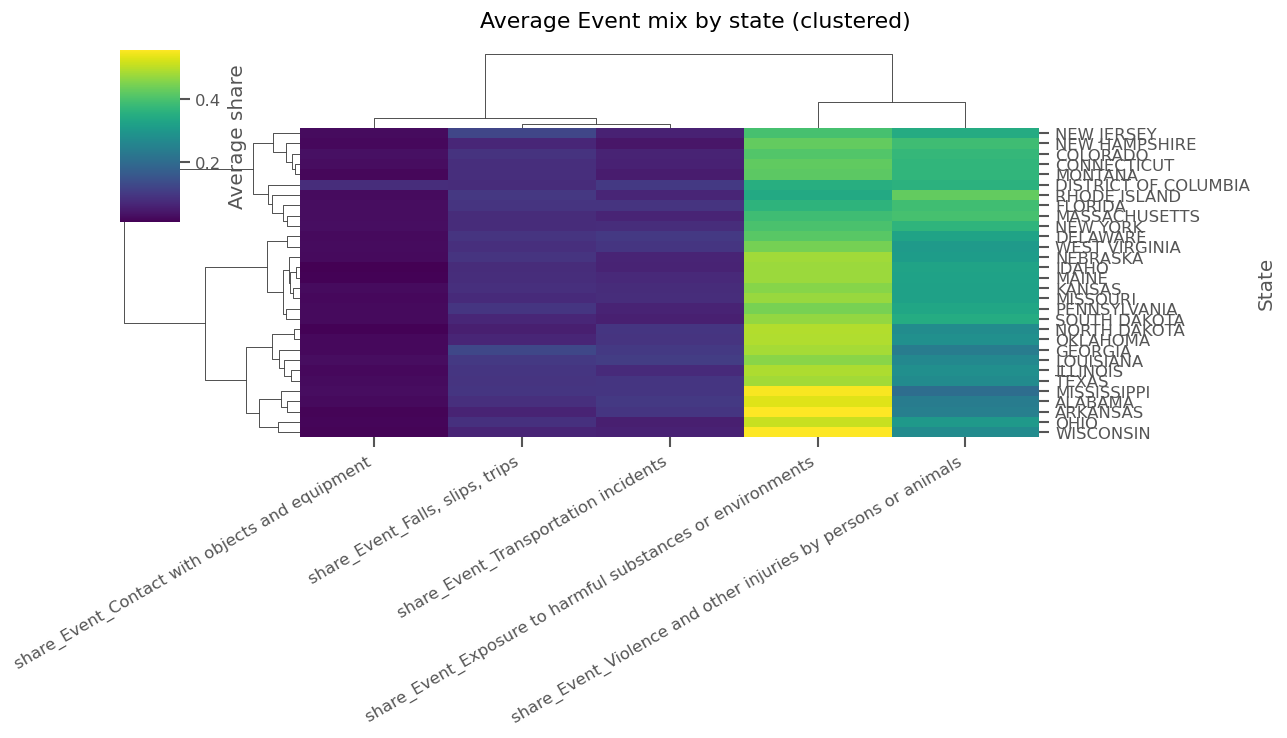

In [29]:
g = sns.clustermap(
    state_event_matrix,
    cmap="viridis",
    method="ward",
    metric="euclidean",
    figsize=(10, 8),
    cbar_kws={"label": "Average share"},
)

# Fix x-axis labels
g.ax_heatmap.set_xticklabels(
    top_event,
    rotation=30,
    ha="right"
)

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("State")
g.fig.suptitle("Average Event mix by state (clustered)", y=1.02)

plt.show()

<Axes: xlabel='Date'>

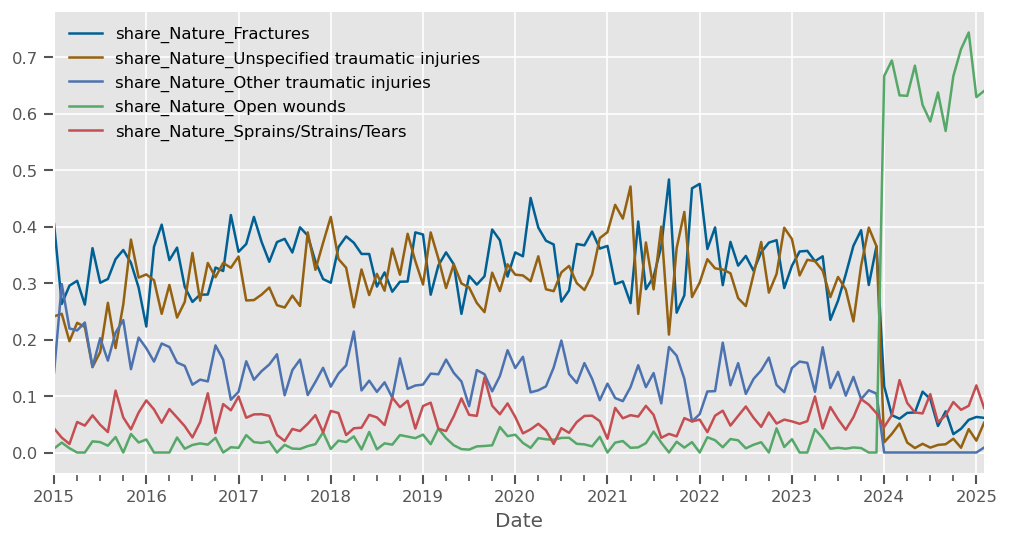

In [30]:
state = "TEXAS"
cols = global_nature_mix.head(5).index

(
    nature_mix[nature_mix["State"] == state]
    .set_index("Date")[cols]
    .plot(figsize=(10, 5))
)


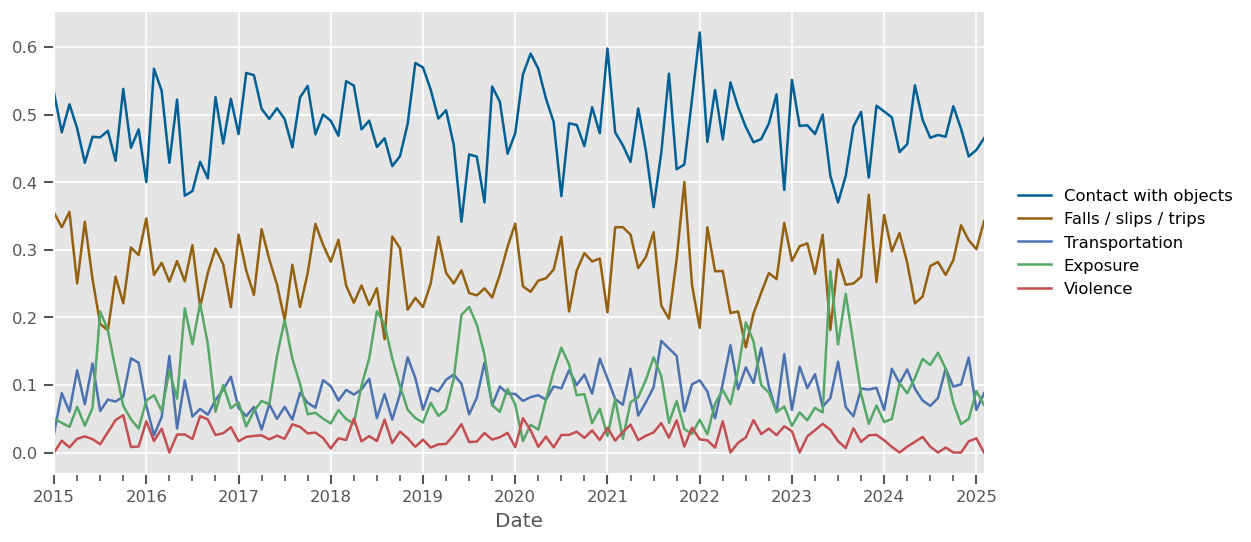

In [47]:
LABEL_MAP = {
    "share_Event_Contact with objects and equipment": "Contact with objects",
    "share_Event_Falls, slips, trips": "Falls / slips / trips",
    "share_Event_Transportation incidents": "Transportation",
    "share_Event_Exposure to harmful substances or environments": "Exposure",
    "share_Event_Violence and other injuries by persons or animals": "Violence",
}

state = "TEXAS"
cols = global_event_mix.head(5).index

(
    event_mix[event_mix["State"] == state]
    .set_index("Date")[cols]
    .plot(figsize=(10, 5))
)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels = [LABEL_MAP.get(l, l) for l in labels]

ax.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)





<Axes: xlabel='Date'>

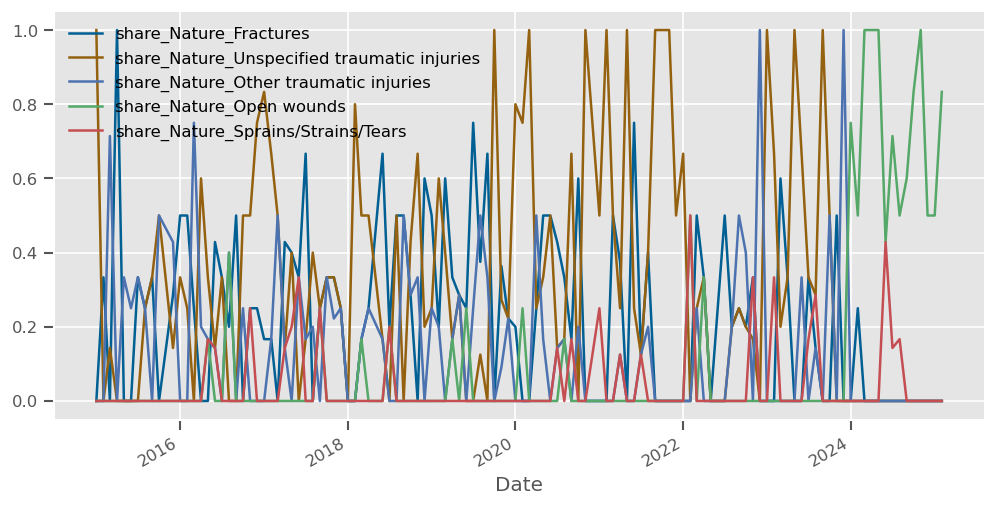

In [49]:
state = "MONTANA"
cols = global_nature_mix.head(5).index

(
    nature_mix[nature_mix["State"] == state]
    .set_index("Date")[cols]
    .plot(figsize=(10, 5))
)


In [33]:
volatility = (
    nature_mix
    .groupby("State")[nature_share_cols]
    .std()
    .mean(axis=1)
)

volatility.describe()


count    30.000000
mean      0.102435
std       0.036539
min       0.061946
25%       0.075058
50%       0.091189
75%       0.123737
max       0.195543
dtype: float64

In [34]:
df["Date"] = pd.to_datetime(df["EventDate"], errors="coerce")

pre_2024 = df[df["Date"] < "2024-01-01"]
post_2024 = df[df["Date"] >= "2024-01-01"]


In [35]:
pre_set = set(pre_2024["Nature"].dropna().unique())
post_set = set(post_2024["Nature"].dropna().unique())

new_after_2024 = sorted(post_set - pre_set)
gone_after_2024 = sorted(pre_set - post_set)

len(new_after_2024), len(gone_after_2024)


(46, 133)

In [36]:
top_new_after_2024 = (
    post_2024[post_2024["Nature"].isin(new_after_2024)]
    .groupby("Nature")
    .size()
    .rename("count")
    .sort_values(ascending=False)
    .head(10)
)

top_new_after_2024


Nature
100     601
103     191
1824    157
1823    152
1112    107
1222    100
1811     94
1113     79
1110     69
1442     48
Name: count, dtype: int64

In [37]:
top_gone_after_2024 = (
    pre_2024[pre_2024["Nature"].isin(gone_after_2024)]
    .groupby("Nature")
    .size()
    .rename("count")
    .sort_values(ascending=False)
    .head(10)
)

top_gone_after_2024


Nature
111     27772
1972     6379
10       1689
1971     1686
194      1479
1839      890
1530      842
143       757
1834      628
193       540
Name: count, dtype: int64

In [50]:
def global_trend(mix_df, share_cols):
    return (
        mix_df
        .groupby("Date")[share_cols]
        .mean()
        .sort_index()
    )


In [51]:
# event-weighted global averages
top3_nature = global_nature_mix.sort_values(ascending=False).head(3).index
top3_event  = global_event_mix.sort_values(ascending=False).head(3).index


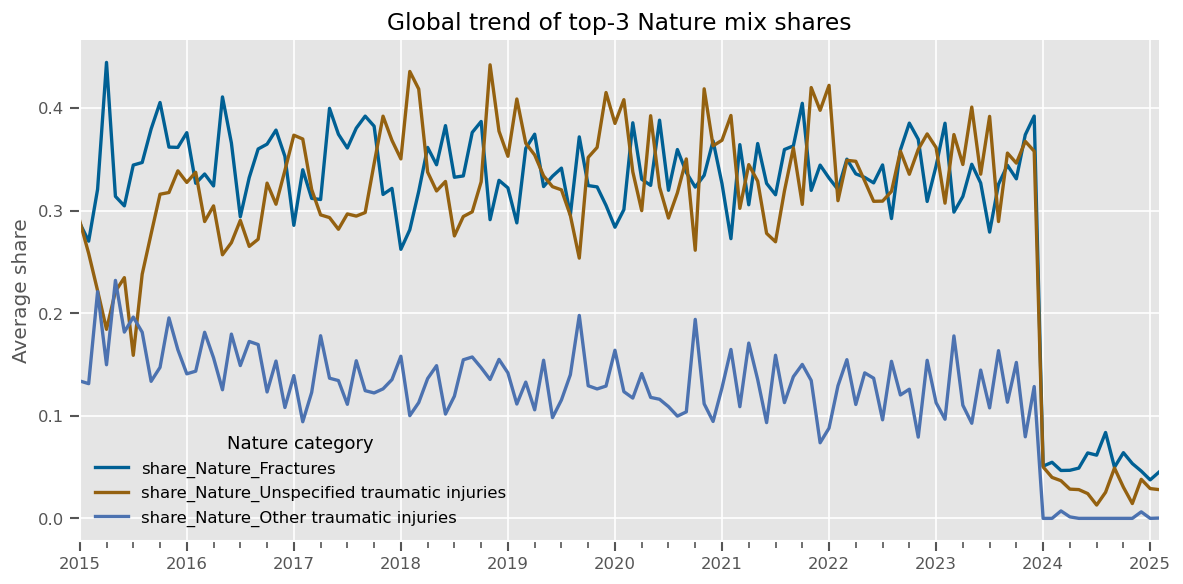

In [52]:
nature_trend = global_trend(nature_mix, top3_nature)

ax = nature_trend.plot(
    figsize=(10, 5),
    linewidth=2
)

ax.set_title("Global trend of top-3 Nature mix shares")
ax.set_ylabel("Average share")
ax.set_xlabel("")
ax.legend(title="Nature category")

plt.tight_layout()
plt.show()


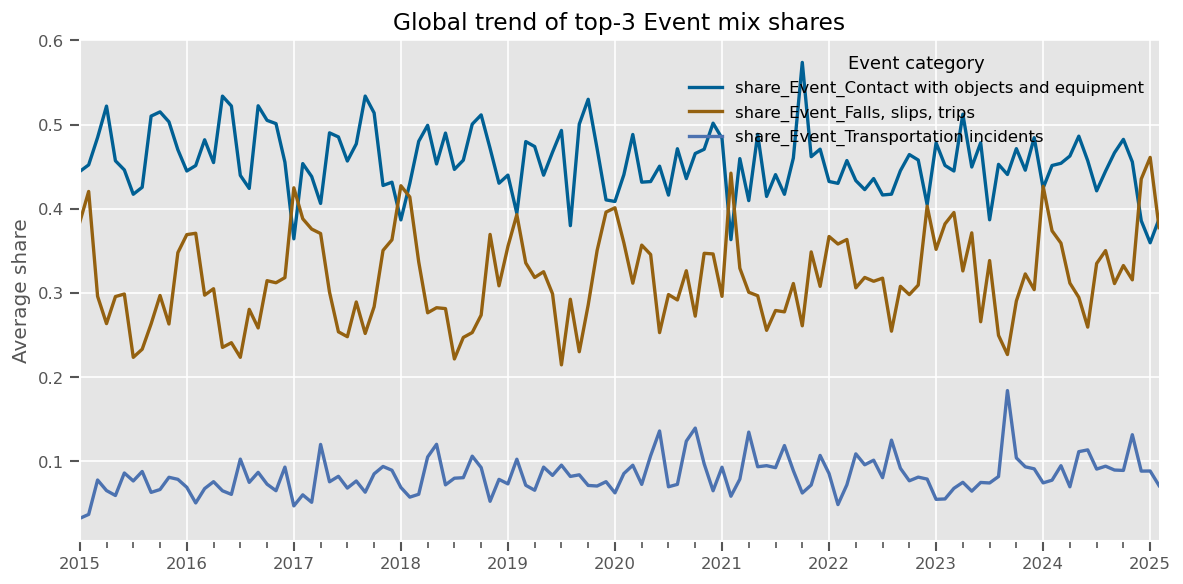

In [53]:
event_trend = global_trend(event_mix, top3_event)

ax = event_trend.plot(
    figsize=(10, 5),
    linewidth=2
)

ax.set_title("Global trend of top-3 Event mix shares")
ax.set_ylabel("Average share")
ax.set_xlabel("")
ax.legend(title="Event category")

plt.tight_layout()
plt.show()


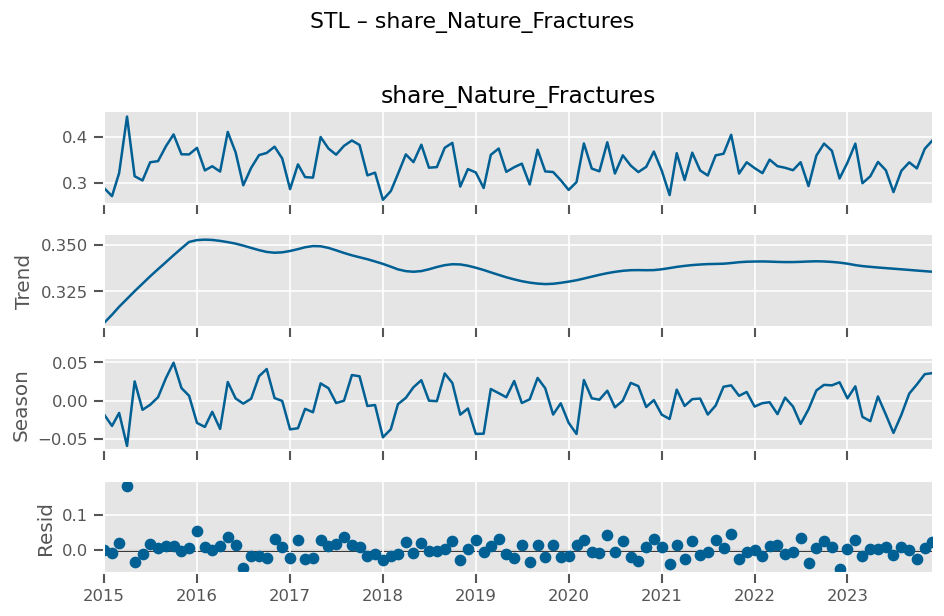

{'trend_strength': 0.03796222020796136, 'seasonal_strength': 0.3277472396059198}


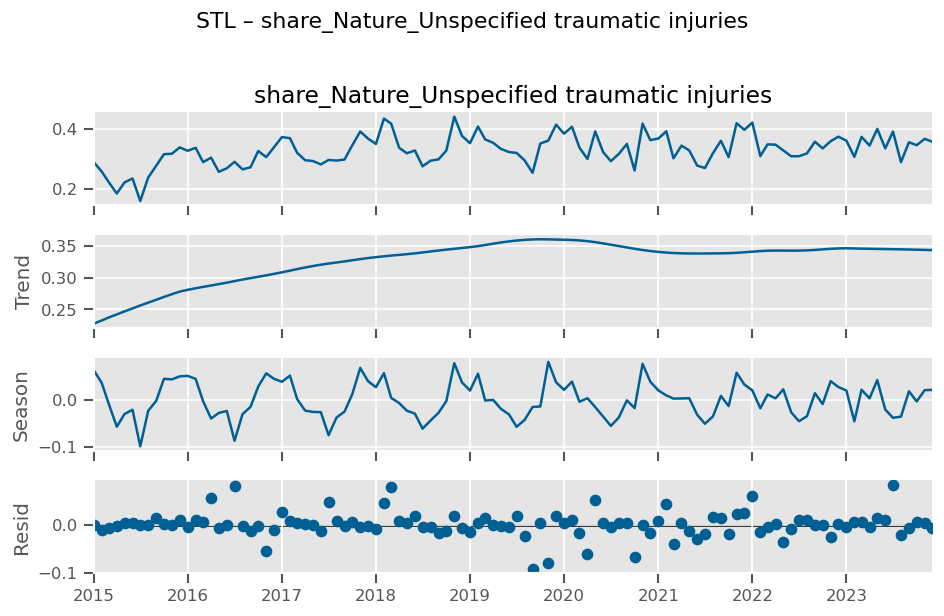

{'trend_strength': 0.5557033500968939, 'seasonal_strength': 0.6081316242659263}


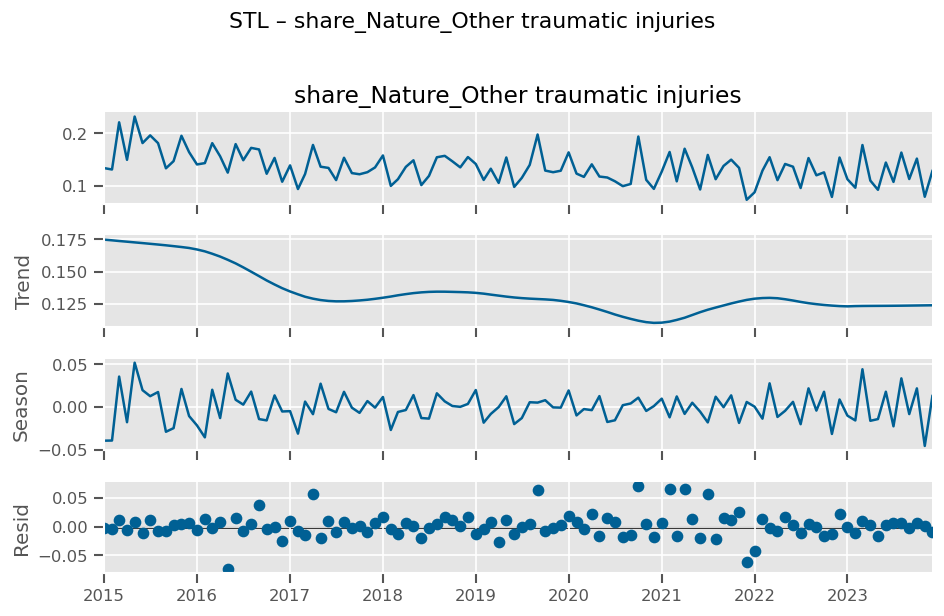

{'trend_strength': 0.31287215156655956, 'seasonal_strength': 0.3667471512473772}


In [54]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def global_series_pre_2024(mix_df, col, cutoff="2024-01-01"):
    s = (
        mix_df
        .groupby("Date")[col]
        .mean()
        .sort_index()
    )
    return s[s.index < cutoff]

def stl_plot(series, period=12, title=None):
    stl = STL(series, period=period, robust=True)
    res = stl.fit()
    res.plot()
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()
    return res

def stl_strength(res):
    return {
        "trend_strength": 1 - res.resid.var() / (res.resid + res.trend).var(),
        "seasonal_strength": 1 - res.resid.var() / (res.resid + res.seasonal).var(),
    }


for col in top3_nature:
    s = global_series_pre_2024(nature_mix, col)
    res = stl_plot(s, period=12, title=f"STL – {col}")
    print(stl_strength(res))

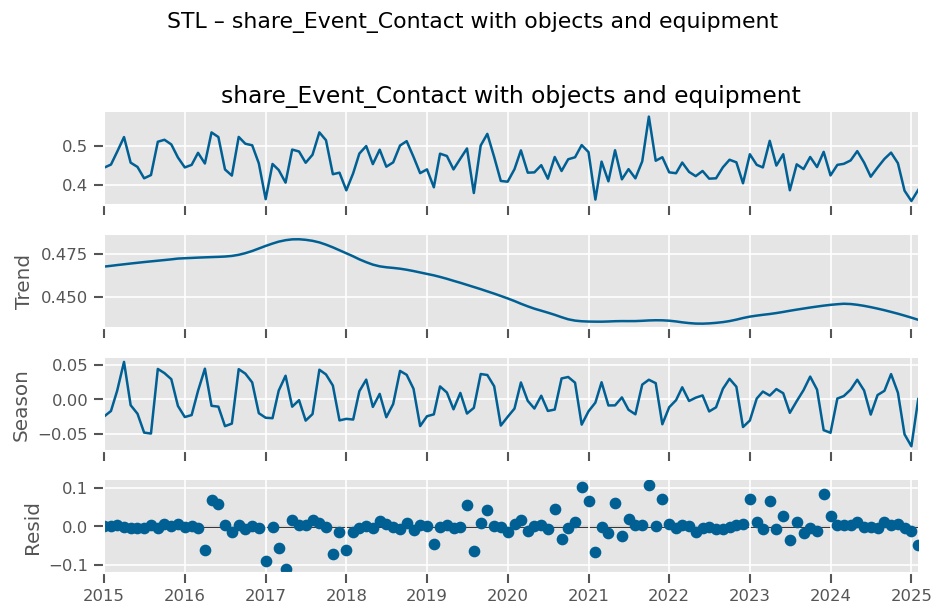

{'trend_strength': 0.003879704471243195, 'seasonal_strength': 0.2994556169514738}


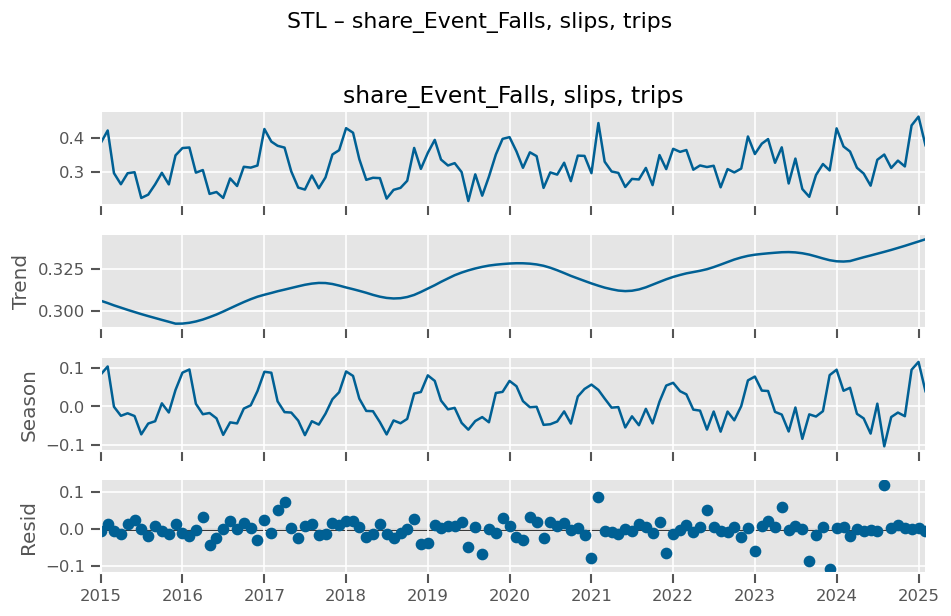

{'trend_strength': 0.17009005779081754, 'seasonal_strength': 0.6982014681075202}


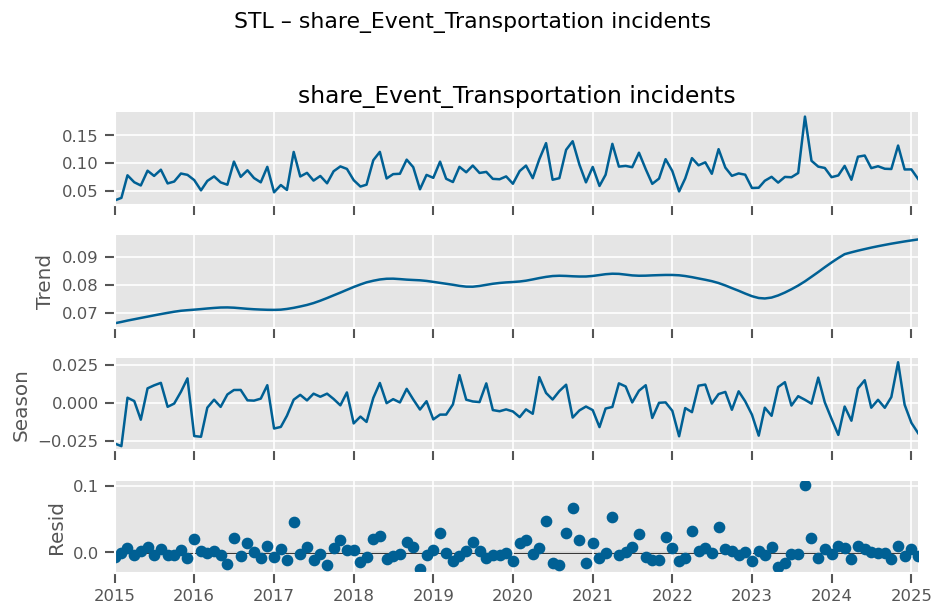

{'trend_strength': 0.17546545660782653, 'seasonal_strength': 0.2809115681262653}


In [55]:
for col in top3_event:
    s = global_trend(event_trend, col)
    res = stl_plot(s, period=12, title=f"STL – {col}")
    print(stl_strength(res))

### Recompute nature and event mix, but this time keep only top 3 features up to 2024-01-01

In [56]:
nature_mix = compute_label_mix(
    df,
    label_col="NatureGroupLabel",
    date_col="EventDate",       # <- set to your event date column name in federal_df
    state_col="State",
    freq="MS",
    top_k=3,
    out_date_col="Date",
    prefix="Nature",
    end_date="2024-01-01"
)

event_mix = compute_label_mix(
    df,
    label_col="EventDivisionLabel",
    date_col="EventDate",
    state_col="State",
    freq="MS",
    top_k=3,
    out_date_col="Date",
    prefix="Event",
    end_date="2024-01-01"
)

In [58]:
nature_mix.columns

Index(['State', 'Date', 'share_Nature_Fractures', 'share_Nature_Other',
       'share_Nature_Other traumatic injuries',
       'share_Nature_Unspecified traumatic injuries'],
      dtype='object')

In [59]:
event_mix.columns

Index(['State', 'Date', 'share_Event_Contact with objects and equipment',
       'share_Event_Falls, slips, trips', 'share_Event_Other',
       'share_Event_Transportation incidents'],
      dtype='object')

In [60]:
panel_df = monthly_complete.merge(nature_mix, on=["State", "Date"], how="left")
panel_df = panel_df.merge(event_mix,  on=["State", "Date"], how="left")
# optional: if a state-month has no federal events, shares should be 0
share_cols = [c for c in panel_df.columns if c.startswith("share_Nature_") or c.startswith("share_Event_")]
panel_df[share_cols] = panel_df[share_cols].fillna(0.0)


In [61]:
panel_df.columns

Index(['State', 'Date', 'HospRisk', 'share_Nature_Fractures',
       'share_Nature_Other', 'share_Nature_Other traumatic injuries',
       'share_Nature_Unspecified traumatic injuries',
       'share_Event_Contact with objects and equipment',
       'share_Event_Falls, slips, trips', 'share_Event_Other',
       'share_Event_Transportation incidents'],
      dtype='object')

In [82]:
rename_map = {
    "share_Nature_Fractures": "share_nature_fractures",
    "share_Nature_Other": "share_nature_other",
    "share_Nature_Other traumatic injuries": "share_nature_other_traumatic",
    "share_Nature_Unspecified traumatic injuries": "share_nature_unspecified_traumatic",

    "share_Event_Contact with objects and equipment": "share_event_contact_objects",
    "share_Event_Falls, slips, trips": "share_event_falls_slips_trips",
    "share_Event_Other": "share_event_other",
    "share_Event_Transportation incidents": "share_event_transportation",
}
panel_df = panel_df.rename(columns=rename_map)

In [63]:
from src.features import build_panel_features

In [83]:
label_mix_cols = [c for c in panel_df.columns if c.startswith("share_nature_") or c.startswith("share_event_")]

label_mix_cols


['share_nature_fractures',
 'share_nature_other',
 'share_nature_other_traumatic',
 'share_nature_unspecified_traumatic',
 'share_event_contact_objects',
 'share_event_falls_slips_trips',
 'share_event_other',
 'share_event_transportation']

In [84]:
from src.features import build_panel_features

X_m, y_m, meta_m = build_panel_features(
    panel_df=panel_df,
    target="HospRisk",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewm_spans=(3, 6, 12),
    label_mix_cols=label_mix_cols,
    dropna=True,
)

X_m.head(), y_m.head(), meta_m.head()


(   year  month  quarter  month_sin     month_cos  HospRisk_lag1  \
 0  2016      1        1   0.500000  8.660254e-01       0.604047   
 1  2016      2        1   0.866025  5.000000e-01       1.458312   
 2  2016      3        1   1.000000  6.123234e-17       0.854744   
 3  2016      4        2   0.866025 -5.000000e-01       0.854186   
 4  2016      5        2   0.500000 -8.660254e-01       1.052368   
 
    HospRisk_lag2  HospRisk_lag3  HospRisk_lag6  HospRisk_lag12  ...  \
 0       0.907441       1.313065       1.268649        0.714760  ...   
 1       0.604047       0.907441       1.164498        0.765072  ...   
 2       1.458312       0.604047       0.758802        1.123538  ...   
 3       0.854744       1.458312       1.313065        1.070064  ...   
 4       0.854186       0.854744       0.907441        1.168046  ...   
 
    HospRisk_ewm6  HospRisk_ewm12  share_nature_fractures_rollmean12_lag1  \
 0       0.915783        0.936564                                0.416409   
 1

In [90]:
corr_df = pd.concat(
    [
        y_m.rename("HospRisk"),
        X_m.filter(regex="share_(nature|event)_.*rollmean12_lag1")
    ],
    axis=1
)


In [91]:
pearson_corr = corr_df.corr(method="pearson")["HospRisk"]
pearson_corr.sort_values(ascending=False)


HospRisk                                              1.000000
share_event_contact_objects_rollmean12_lag1           0.313070
share_nature_fractures_rollmean12_lag1                0.215910
share_nature_unspecified_traumatic_rollmean12_lag1    0.038390
share_event_other_rollmean12_lag1                     0.001792
share_nature_other_traumatic_rollmean12_lag1         -0.053372
share_event_transportation_rollmean12_lag1           -0.095605
share_nature_other_rollmean12_lag1                   -0.106580
share_event_falls_slips_trips_rollmean12_lag1        -0.250605
Name: HospRisk, dtype: float64

In [92]:
spearman_corr = corr_df.corr(method="spearman")["HospRisk"]
spearman_corr.sort_values(ascending=False)


HospRisk                                              1.000000
share_event_contact_objects_rollmean12_lag1           0.324869
share_nature_fractures_rollmean12_lag1                0.228509
share_event_other_rollmean12_lag1                     0.022409
share_nature_unspecified_traumatic_rollmean12_lag1    0.016313
share_event_transportation_rollmean12_lag1           -0.054392
share_nature_other_traumatic_rollmean12_lag1         -0.063886
share_nature_other_rollmean12_lag1                   -0.124636
share_event_falls_slips_trips_rollmean12_lag1        -0.264371
Name: HospRisk, dtype: float64

In [93]:
state_corrs = (
    pd.concat([corr_df, meta_m["State"]], axis=1)
      .groupby("State")
      .apply(lambda g: g.drop(columns=["State"]).corr(numeric_only=True)["HospRisk"])
)


summary = pd.DataFrame({
    "mean_corr": state_corrs.mean(),
    "std_corr": state_corrs.std(),
    "sign_consistency": (state_corrs > 0).mean()
})

summary.sort_values("mean_corr", ascending=False)


C:\Users\esper\AppData\Local\Temp\ipykernel_26696\608300648.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.drop(columns=["State"]).corr(numeric_only=True)["HospRisk"])


,mean_corr,std_corr,sign_consistency
HospRisk,,,
HospRisk,1.000000,0.000000,1.000000
share_nature_other_traumatic_rollmean12_lag1,0.131553,0.141040,0.800000
share_nature_fractures_rollmean12_lag1,0.106125,0.118541,0.833333
share_nature_unspecified_traumatic_rollmean12_lag1,0.077243,0.115082,0.800000
share_event_other_rollmean12_lag1,0.070833,0.151187,0.700000
share_event_contact_objects_rollmean12_lag1,0.059333,0.186762,0.666667
share_event_falls_slips_trips_rollmean12_lag1,-0.052403,0.184743,0.433333
share_event_transportation_rollmean12_lag1,-0.074506,0.179856,0.366667
share_nature_other_rollmean12_lag1,-0.121353,0.091654,0.100000


In [94]:
# Columns to include
feat_cols = X_m.filter(regex="share_(nature|event)_.*rollmean12_lag1").columns

corr_mat = (
    pd.concat([y_m.rename("HospRisk"), X_m[feat_cols]], axis=1)
      .corr(method="pearson")
)

# Keep only feature–feature correlations (drop HospRisk row/col if desired)
corr_feat = corr_mat.loc[feat_cols, feat_cols]


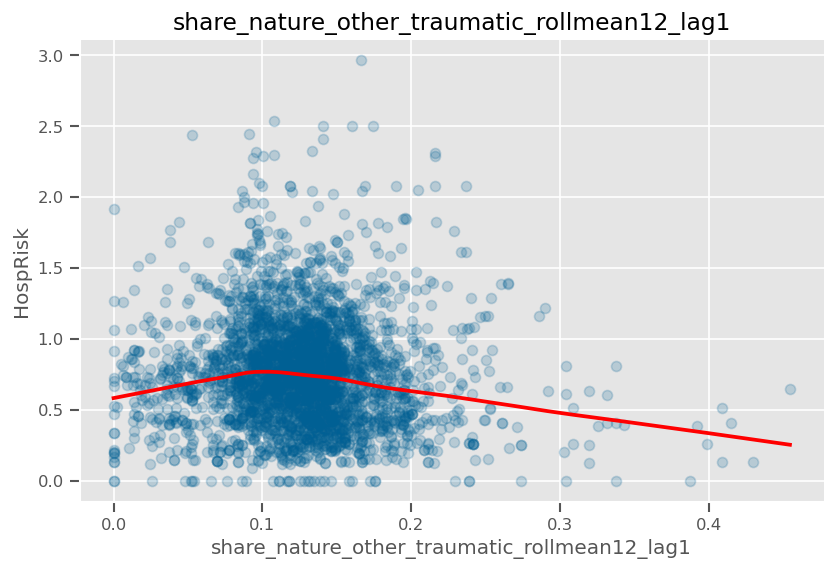

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

feature = "share_nature_other_traumatic_rollmean12_lag1"

sns.regplot(
    x=X_m[feature],
    y=y_m,
    lowess=True,
    scatter_kws={"alpha": 0.2},
    line_kws={"color": "red"}
)
plt.title(feature)
plt.show()



C:\Users\esper\AppData\Local\Temp\ipykernel_26696\1830953057.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = y_m.groupby(bins).mean()


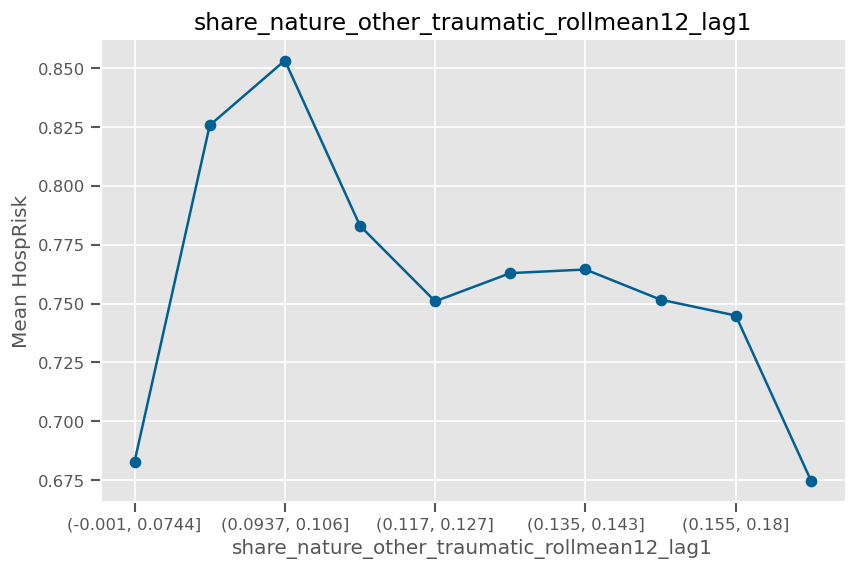

In [98]:
bins = pd.qcut(X_m[feature], q=10, duplicates="drop")
binned = y_m.groupby(bins).mean()

binned.plot(marker="o")
plt.title(feature)
plt.ylabel("Mean HospRisk")
plt.show()

In [99]:
(X_m[feat_cols] == 0).mean().sort_values(ascending=False)


share_event_transportation_rollmean12_lag1            0.009568
share_nature_other_traumatic_rollmean12_lag1          0.006173
share_nature_unspecified_traumatic_rollmean12_lag1    0.000617
share_nature_other_rollmean12_lag1                    0.000000
share_nature_fractures_rollmean12_lag1                0.000000
share_event_contact_objects_rollmean12_lag1           0.000000
share_event_falls_slips_trips_rollmean12_lag1         0.000000
share_event_other_rollmean12_lag1                     0.000000
dtype: float64

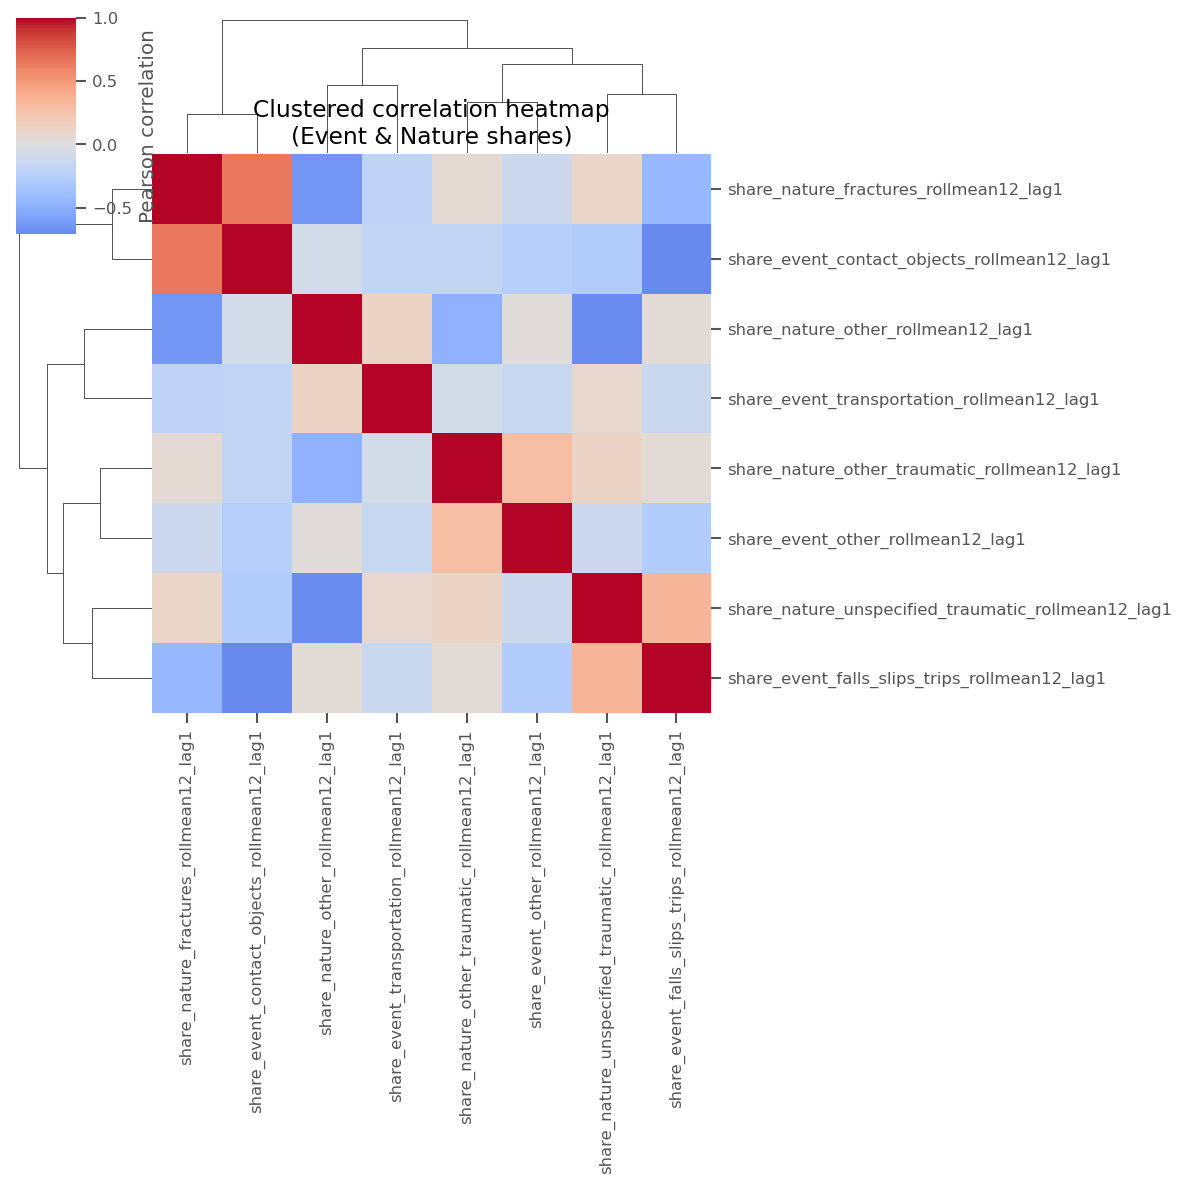

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(
    corr_feat,
    cmap="coolwarm",
    center=0,
    method="ward",
    metric="euclidean",
    figsize=(10, 10),
    cbar_kws={"label": "Pearson correlation"},
)

g.ax_heatmap.set_title("Clustered correlation heatmap\n(Event & Nature shares)")
plt.show()


In [ ]:
from src.RQ1_utils import yearly_train_ends, rolling_origin_masks

train_ends = yearly_train_ends(meta_m, date_col="Date")
splits = rolling_origin_masks(meta_m, date_col="Date", train_ends=train_ends, test_size=12)

len(train_ends), len(splits)


(9, 8)

In [77]:
split_calendar = pd.DataFrame([
    {
        "train_end": s["train_end"].date(),
        "test_start": s["test_start"].date(),
        "test_end": s["test_end"].date(),
        "train_weeks": s["n_train_weeks"],
        "test_weeks": s["n_test_weeks"],
        "train_rows": s["n_train_rows"],
        "test_rows": s["n_test_rows"],
    }
    for s in splits
])

split_calendar.head(10)


,train_end,test_start,test_end,train_weeks,test_weeks,train_rows,test_rows
0,2016-12-01,2017-01-01,2017-12-01,12,12,360,360
1,2017-12-01,2018-01-01,2018-12-01,24,12,720,360
2,2018-12-01,2019-01-01,2019-12-01,36,12,1080,360
3,2019-12-01,2020-01-01,2020-12-01,48,12,1440,360
4,2020-12-01,2021-01-01,2021-12-01,60,12,1800,360
5,2021-12-01,2022-01-01,2022-12-01,72,12,2160,360
6,2022-12-01,2023-01-01,2023-12-01,84,12,2520,360
7,2023-12-01,2024-01-01,2024-12-01,96,12,2880,360


In [78]:
# train_end dates to keep
keep_train_ends = {
    pd.Timestamp("2018-12-01"),
    pd.Timestamp("2019-12-01"),
    pd.Timestamp("2020-12-01"),
    pd.Timestamp("2021-12-01"),
    pd.Timestamp("2022-12-01"),
}

# filter splits
splits_origins = [
    s for s in splits
    if pd.Timestamp(s["train_end"]) in keep_train_ends
]

len(splits_origins), [s["train_end"].date() for s in splits_origins]


(5,
 [datetime.date(2018, 12, 1),
  datetime.date(2019, 12, 1),
  datetime.date(2020, 12, 1),
  datetime.date(2021, 12, 1),
  datetime.date(2022, 12, 1)])

In [79]:
from src.models import get_model_configs, instantiate_models
from src.training import fit_global_models

In [153]:
from src.RQ1_utils import run_global

In [154]:
from src.config import RESULTS_DIR

In [155]:
horizons = [1, 3, 6]

preds_m, metrics_m, perm_m = run_global(
    X=X_m,
    y=y_m,
    meta=meta_m,
    splits=splits_origins,
    horizons=horizons,
    group_col="State",
    date_col="Date",
    seasonal_period=12,
    use_linear=True,
    use_tree=True,
    compute_perm_importance=True,          
    savedir=RESULTS_DIR,          
    run_name="monthly_global_with_exg",
)


In [156]:
from src.RQ1_utils import (
    summarize_metrics_mean_std,
    plot_stability_across_splits,
    plot_fit_and_forecast,
    plot_rmse_per_fold, 
)

In [157]:
monthly_h1_exg = summarize_metrics_mean_std(metrics_m, horizon=1)

monthly_h1_exg

,RMSE,MAE,MASE
model,,,
CatBoost,0.288 ± 0.024,0.212 ± 0.024,0.733 ± 0.090
ElasticNet,0.289 ± 0.021,0.212 ± 0.019,0.738 ± 0.064
Lasso,0.288 ± 0.021,0.212 ± 0.019,0.735 ± 0.065
LightGBM,0.291 ± 0.023,0.214 ± 0.024,0.746 ± 0.089
PLS,0.290 ± 0.021,0.214 ± 0.019,0.743 ± 0.067
Ridge,0.290 ± 0.022,0.214 ± 0.019,0.744 ± 0.067
Seasonal Naive,0.398 ± 0.034,0.282 ± 0.025,0.956 ± 0.084
XGBoost,0.297 ± 0.023,0.217 ± 0.024,0.751 ± 0.093


In [158]:
monthly_h3_exg = summarize_metrics_mean_std(metrics_m, horizon=3)
monthly_h3_exg

,RMSE,MAE,MASE
model,,,
CatBoost,0.289 ± 0.030,0.211 ± 0.027,0.732 ± 0.091
ElasticNet,0.286 ± 0.025,0.209 ± 0.021,0.729 ± 0.067
Lasso,0.285 ± 0.025,0.208 ± 0.021,0.724 ± 0.067
LightGBM,0.293 ± 0.030,0.215 ± 0.029,0.753 ± 0.104
PLS,0.286 ± 0.026,0.209 ± 0.022,0.730 ± 0.072
Ridge,0.287 ± 0.026,0.210 ± 0.022,0.735 ± 0.068
Seasonal Naive,0.396 ± 0.035,0.280 ± 0.027,0.951 ± 0.091
XGBoost,0.296 ± 0.032,0.216 ± 0.029,0.751 ± 0.100


In [159]:
monthly_h6_exg = summarize_metrics_mean_std(metrics_m, horizon=6)
monthly_h6_exg

,RMSE,MAE,MASE
model,,,
CatBoost,0.293 ± 0.034,0.213 ± 0.032,0.743 ± 0.113
ElasticNet,0.288 ± 0.027,0.211 ± 0.025,0.749 ± 0.087
Lasso,0.287 ± 0.026,0.211 ± 0.025,0.745 ± 0.085
LightGBM,0.290 ± 0.033,0.213 ± 0.030,0.755 ± 0.105
PLS,0.289 ± 0.027,0.212 ± 0.025,0.751 ± 0.087
Ridge,0.289 ± 0.027,0.212 ± 0.026,0.753 ± 0.090
Seasonal Naive,0.391 ± 0.032,0.276 ± 0.027,0.945 ± 0.088
XGBoost,0.297 ± 0.037,0.217 ± 0.035,0.763 ± 0.117


In [160]:
monthly_h3_exg.to_csv(RESULTS_DIR / 'monthly_h3_exg.csv')

In [161]:
from src.RQ1_utils import summarize_perm_importance, plot_perm_importance_bar

In [162]:
pi_ridge_h3 = summarize_perm_importance(
    perm_m,
    model="Ridge",
    horizon=3,
)

pi_ridge_h3

,mean_importance,std_importance,pos_frac
feature,,,
HospRisk_rollmean12,0.172046,0.097809,1.0
quarter,0.072238,0.012009,1.0
month,0.031513,0.006861,1.0
HospRisk_rollmean6,0.025794,0.025810,1.0
month_sin,0.015493,0.002167,1.0
HospRisk_ewm12,0.012892,0.015080,0.8
share_event_falls_slips_trips_rollmean12_lag1,0.007194,0.006320,1.0
HospRisk_ewm3,0.006964,0.007041,1.0
share_nature_fractures_rollmean12_lag1,0.005793,0.005151,1.0


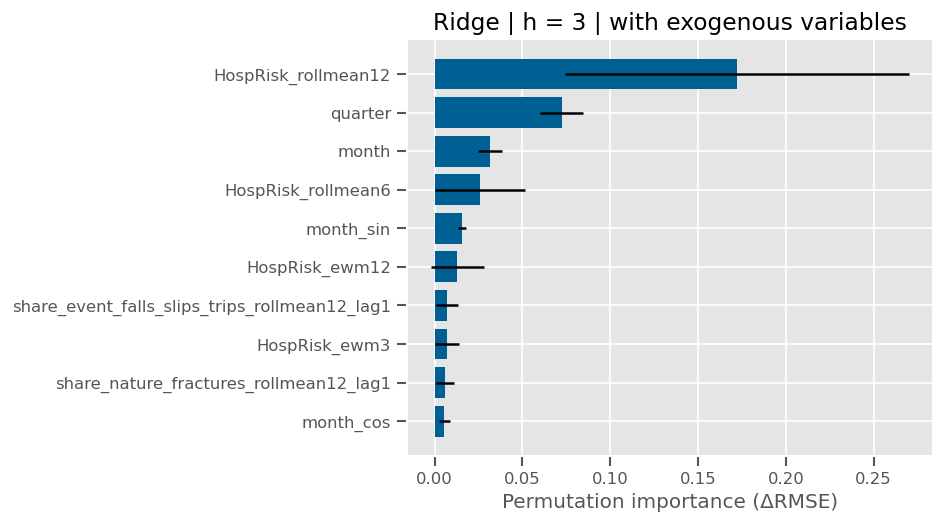

In [163]:
plot_perm_importance_bar(pi_ridge_h3, title="Ridge | h = 3 | with exogenous variables")

In [164]:
pi_catboost_h3 = summarize_perm_importance(
    perm_m,
    model="CatBoost",
    horizon=3,
)

pi_catboost_h3

,mean_importance,std_importance,pos_frac
feature,,,
HospRisk_rollmean12,0.030456,0.016853,1.0
HospRisk_ewm12,0.010667,0.008202,0.8
month,0.002662,0.000539,1.0
month_sin,0.001846,0.001344,1.0
HospRisk_lag12,0.001614,0.001984,0.8
month_cos,0.001290,0.001398,1.0
HospRisk_ewm3,0.001275,0.001445,0.8
HospRisk_rollmean6,0.001120,0.001206,1.0
HospRisk_ewm6,0.000987,0.003020,0.6


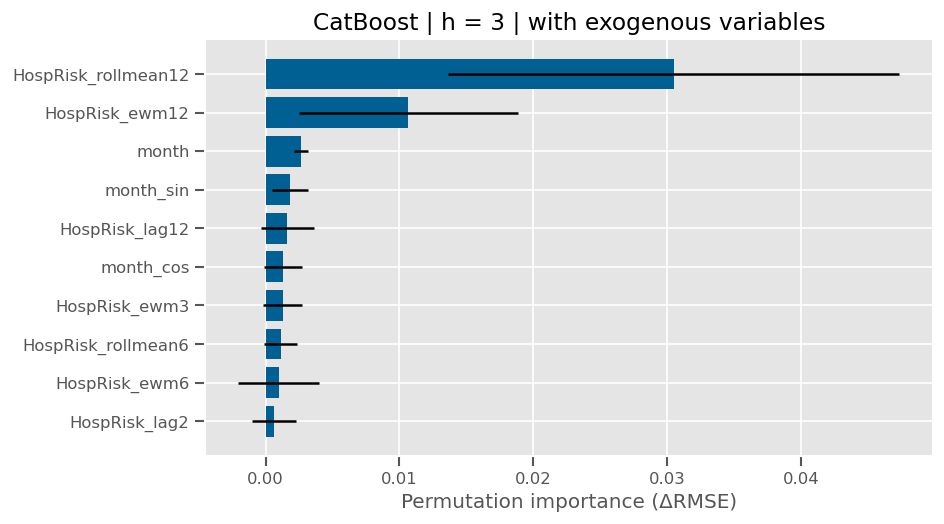

In [165]:
plot_perm_importance_bar(pi_catboost_h3, title='CatBoost | h = 3 | with exogenous variables')

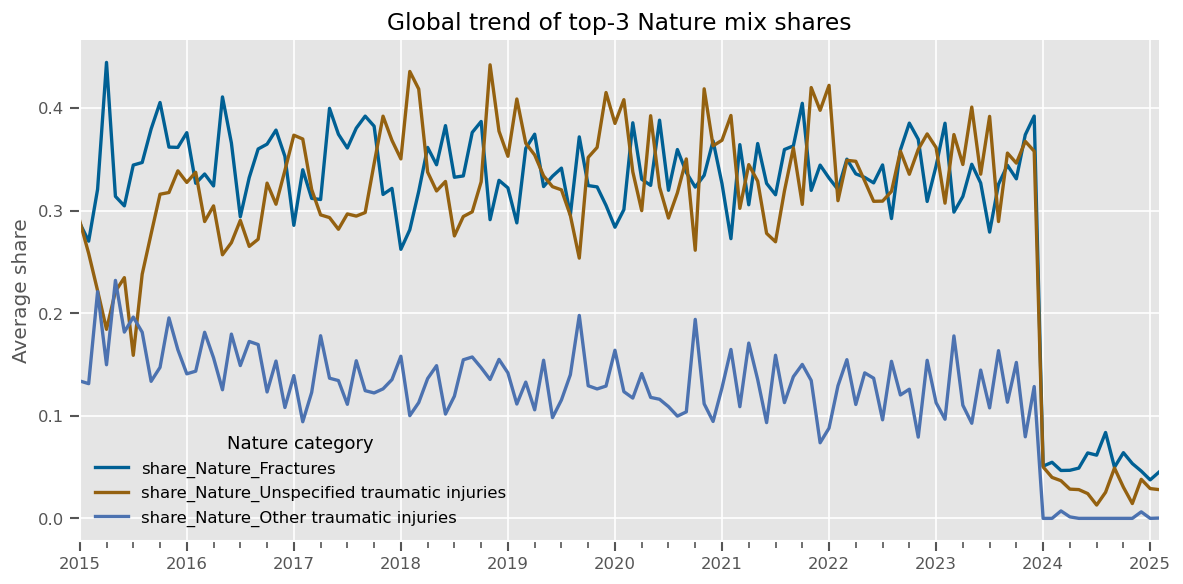

In [ ]:
nature_trend = global_trend(nature_mix, top3_nature)

ax = nature_trend.plot(
    figsize=(10, 5),
    linewidth=2
)

ax.set_title("Global trend of top-3 Nature mix shares")
ax.set_ylabel("Average share")
ax.set_xlabel("")
ax.legend(title="Nature category")

plt.tight_layout()
plt.show()


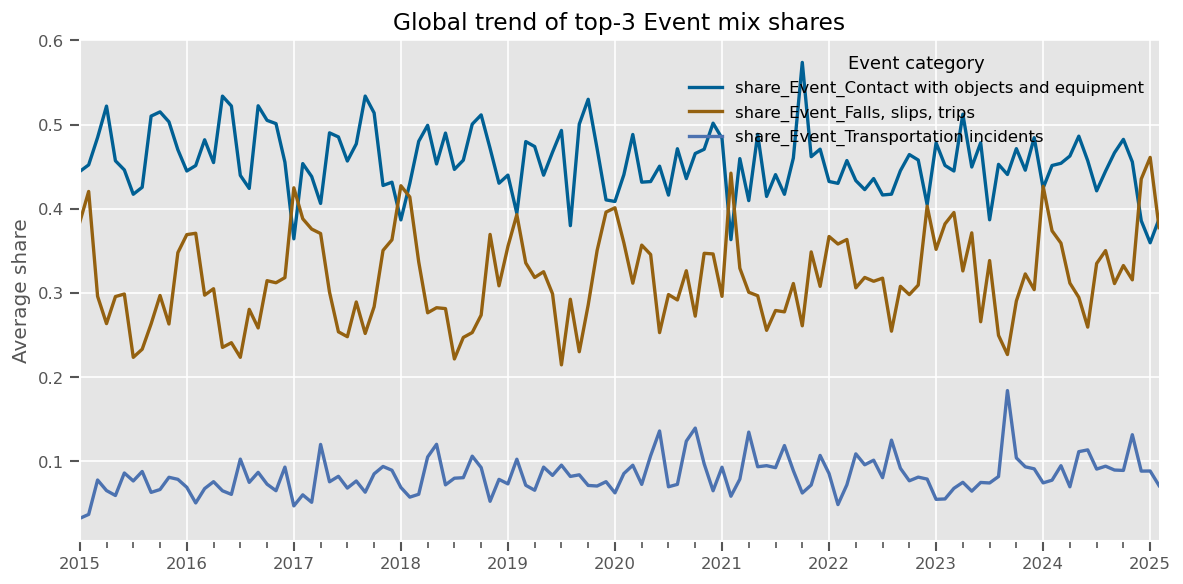

In [ ]:
event_trend = global_trend(event_mix, top3_event)

ax = event_trend.plot(
    figsize=(10, 5),
    linewidth=2
)

ax.set_title("Global trend of top-3 Event mix shares")
ax.set_ylabel("Average share")
ax.set_xlabel("")
ax.legend(title="Event category")

plt.tight_layout()
plt.show()
